# TP2
### Alumno: Gonzalo Gontad

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd

### Implementar la función create_gauss_filter(h, w, k_size, sigma) para crear filtros gaussianos para filtrado espectral. Debe retornar un filtro gaussiano de tamaño HxW en dominio espacial y su transformada de Fourier.
1. Graficar ambas representaciones para diferentes tamaños de kernel y sigma. Aplicar el filtro una 
imagen para validar el funcionamiento en el dominio espectral. 
2. Usando el método descripto en el paper “Image Sharpness Measure for Blurred Images in Frequency 
Domain” comparar el resultado de un filtrado por convolución con el filtrado espectral.
3. Repetir la comparación usando uno de los métodos descriptos en el apéndice del paper “Analysis of 
focus measure operators in shape-from-focus”

### 1

Creo la funcion create_gauss_filter(h, w, k_size, sigma) 

In [2]:
def create_gauss_filter(h, w, k_size=15, sigma=5):
    #Creo el kernel
    kernel = cv.getGaussianKernel(k_size, sigma)
    kernel = kernel @ kernel.T
    #Agregar padding
    vertical_pad = ((h - k_size) // 2, np.ceil((h - k_size) / 2).astype(int))
    horizontal_pad = ((w - k_size) // 2, np.ceil((w - k_size) / 2).astype(int))
    kernel = np.pad(kernel, (vertical_pad,horizontal_pad ), "constant", constant_values=0)
    # Retorno kernel y su transformada de fourier
    return kernel, np.fft.fft2(kernel)

Creo varios kernels de distintos tamaños y sigma 

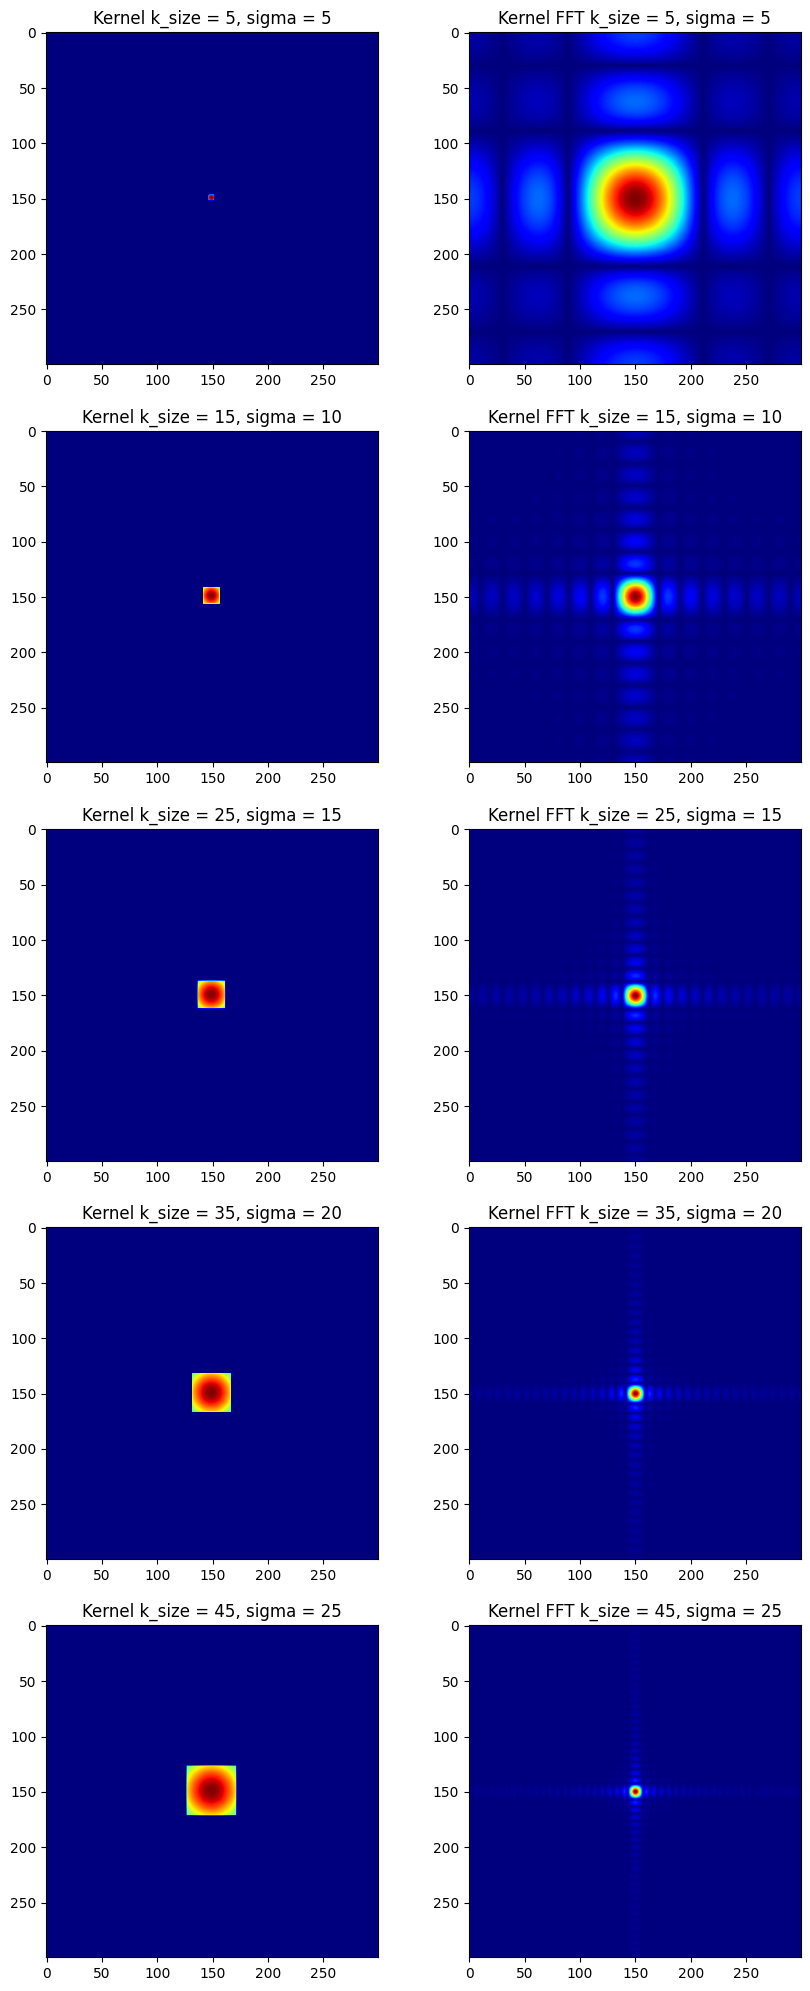

In [3]:
k_sizes = [5, 15, 25, 35, 45]
sigmas = [5, 10, 15, 20, 25]
fig, axes = plt.subplots(len(k_sizes), 2, figsize=(10, 5*len(k_sizes)))
for i, k_size in enumerate(k_sizes):
    kernel, kernel_fft = create_gauss_filter(300, 300, k_size, sigmas[i]) #Uso un tamaño de imagen 300x300 para visualizar
    axes[i, 0].imshow(kernel, cmap='jet')
    axes[i, 0].set_title('Kernel k_size = {}, sigma = {}'.format(k_size, sigmas[i]))
    axes[i, 1].imshow(np.abs(np.fft.fftshift(kernel_fft)), cmap='jet') #Uso fftshift para centrar la transformada
    axes[i, 1].set_title('Kernel FFT k_size = {}, sigma = {}'.format(k_size, sigmas[i]))

Prueba con imagen en el dominio espectral

In [4]:
path = "TP1/segmentacion.png"
image = cv.imread(path, cv.IMREAD_GRAYSCALE)


In [5]:
k_size = 9
sigma = 5

Text(0.5, 1.0, 'Imagen filtrada en el espacio')

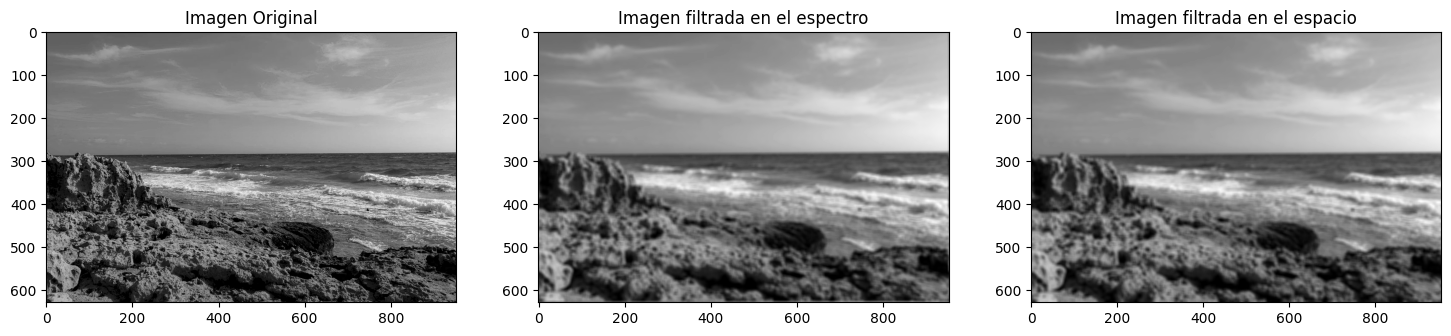

In [6]:
filtro, filtro_fft = create_gauss_filter(image.shape[0],image.shape[1],k_size=k_size,sigma=sigma)
#Filtrado en el espectro
image_fft = np.fft.fft2(image)
image_filtered_spec = image_fft * filtro_fft
image_filtered_spec = np.fft.ifftshift(np.real(np.fft.ifft2(image_filtered_spec))).astype(np.uint8) #hago la inversa de la transformada y shift

#Filtrado en el espacio
image_filtered_space = cv.GaussianBlur(image, (k_size,k_size), sigma)

#Tambien se puede hacer de esta forma el filtrado en el espacio
#image_filtered_space = cv.filter2D(image, -1, filtro) 

#plot the image
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 12))
ax1.imshow(image, cmap='gray')
ax1.set_title(f'Imagen Original')
ax2.imshow(image_filtered_spec, cmap='gray')
ax2.set_title(f'Imagen filtrada en el espectro')
ax3.imshow(image_filtered_space, cmap='gray')
ax3.set_title(f'Imagen filtrada en el espacio')


### 2 y 3

“Image Sharpness Measure for Blurred Images in Frequency Domain” 

In [7]:
def FM_calc (image):
    F = np.fft.fft2(image)
    Fc = np.fft.fftshift(F)
    AF = np.abs(Fc)
    Max_AF = np.max(AF)
    Th = len(F[F > Max_AF/1000])
    FM = Th / (image.shape[0] * image.shape[1])
    return FM

    

“Analysis of focus measure operators in shape-from-focus” - Absolute central moment 

In [8]:
#Calc Absolute central moment 
def ACM_calc (image):
    ACM=0
    histogram = cv.calcHist([image], [0], None, [256], [0, 256])
    mean = np.mean(image)
    for i in range (len(histogram)):
        ACM += histogram[i] * np.abs(i - mean)
    ACM = ACM / (image.shape[0] * image.shape[1])
    return ACM[0]
    

In [9]:
k_size = 9
sigma = 5

Text(0.5, 1.0, 'Imagen filtrada en el espacio - \nFM = 0.00185\nACM = 38.87306')

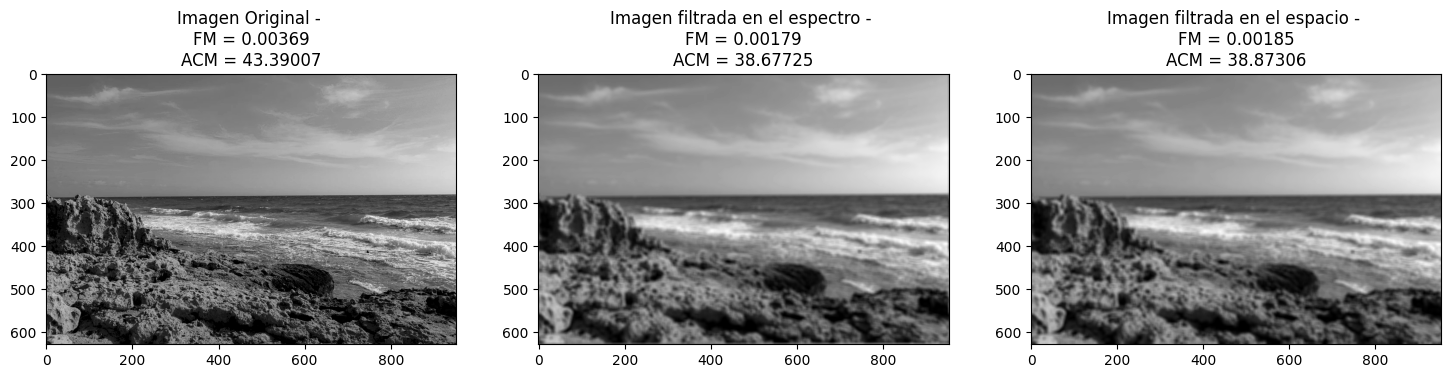

In [10]:
# Calculo los filtros
filtro, filtro_fft = create_gauss_filter(image.shape[0],image.shape[1],k_size=k_size,sigma=sigma)
image_fft = np.fft.fft2(image)
image_filtered_spec = image_fft * filtro_fft
image_filtered_spec = np.fft.ifftshift(np.real(np.fft.ifft2(image_filtered_spec))).astype(np.uint8)
#image_filtered_space = cv.filter2D(image, -1, filtro)
image_filtered_space = cv.GaussianBlur(image, (k_size,k_size), sigma)

# Grafico las imagenes y agrego las metricas de FM y ACM
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 12))
ax1.imshow(image, cmap='gray')
ax1.set_title(f'Imagen Original - \nFM = {FM_calc(image):.5f}\nACM = {ACM_calc(image):.5f}') 
ax2.imshow(image_filtered_spec, cmap='gray')
ax2.set_title(f'Imagen filtrada en el espectro - \nFM = {FM_calc(image_filtered_spec):.5f}\nACM = {ACM_calc(image_filtered_spec):.5f}')
ax3.imshow(image_filtered_space, cmap='gray')
ax3.set_title(f'Imagen filtrada en el espacio - \nFM = {FM_calc(image_filtered_space):.5f}\nACM = {ACM_calc(image_filtered_space):.5f}')


In [11]:
#Borro un warning de pandas :|
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

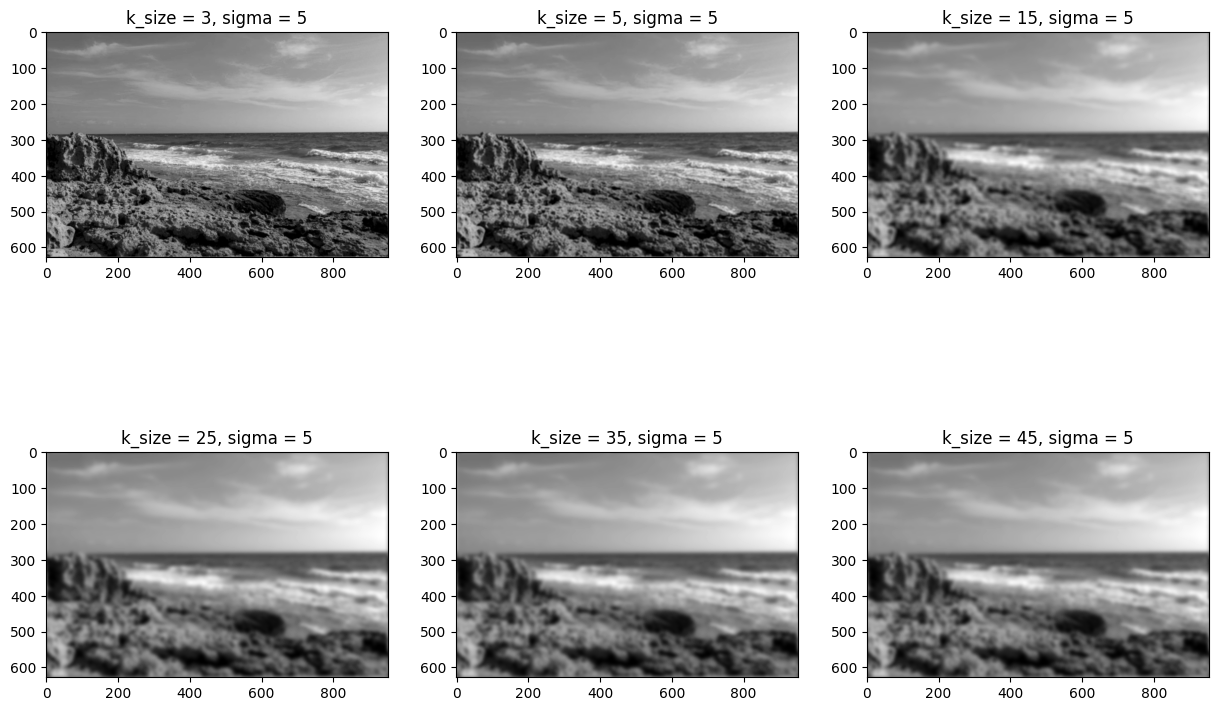

In [12]:
#Calculo de FM y ACM para varios tamaños de kernel y sigma 
k_sizes = [3, 5, 15, 25, 35, 45] #kernels 5x5, 15x15, 25x25, 35x35, 45x45
sigmas = [5, 5, 10, 15, 20, 25]

#Creo un dataframe para guardar los resultados
df_metrics = pd.DataFrame(columns=['k_size', 'sigma', 'FM_SPEC', 'ACM_SPEC', 'FM_SPACE', 'ACM_SPACE'])

_,axes = plt.subplots(int(np.ceil(len(k_sizes)/3)), 3, figsize=(15, 5*np.ceil(len(k_sizes)/3)))
for i, k_size in enumerate(k_sizes):
    for j, sigma in enumerate(sigmas):
        filtro, filtro_fft = create_gauss_filter(image.shape[0],image.shape[1],k_size=k_size,sigma=sigma)

        #Filtro la imagen con GaussianBlur 
        image_filtered_space = cv.GaussianBlur(image, (k_size,k_size), sigma)
        #image_filtered_space = cv.filter2D(image, -1, filtro) #Podria hacerse de esta forma tambien

        #Filtro la imagen en el espectro
        image_filtered_spec = image_fft * filtro_fft
        image_filtered_spec = np.fft.ifftshift(np.real(np.fft.ifft2(image_filtered_spec))).astype(np.uint8)
        
        #Calculo metricas
        df_metrics = df_metrics.append({
            'k_size': k_size, 
            'sigma': sigma, 
            'FM_SPEC': FM_calc(image_filtered_spec), 
            'ACM_SPEC': ACM_calc(image_filtered_spec), 
            'FM_SPACE': FM_calc(image_filtered_space), 
            'ACM_SPACE': ACM_calc(image_filtered_space)}, 
            ignore_index=True)

        #Grafico uno los casos del primer valor de sigma
        if j==0:
            axes[i//3, i%3].imshow(image_filtered_spec, cmap='gray')
            axes[i//3, i%3].set_title(f'k_size = {k_size}, sigma = {sigma}')
            

In [13]:
df_metrics

,k_size,sigma,FM_SPEC,ACM_SPEC,FM_SPACE,ACM_SPACE
0,3.0,5.0,0.003143,40.666591,0.003166,40.752201
1,3.0,5.0,0.003143,40.666591,0.003166,40.752201
2,3.0,10.0,0.003143,40.669953,0.003166,40.752201
3,3.0,15.0,0.003140,40.666310,0.003166,40.752201
4,3.0,20.0,0.003140,40.668202,0.003166,40.752201
5,3.0,25.0,0.003140,40.663867,0.003166,40.752201
6,5.0,5.0,0.002568,39.716781,0.002612,39.829857
7,5.0,5.0,0.002568,39.716781,0.002612,39.829857
8,5.0,10.0,0.002558,39.700794,0.002582,39.808556
9,5.0,15.0,0.002555,39.698568,0.002582,39.808556


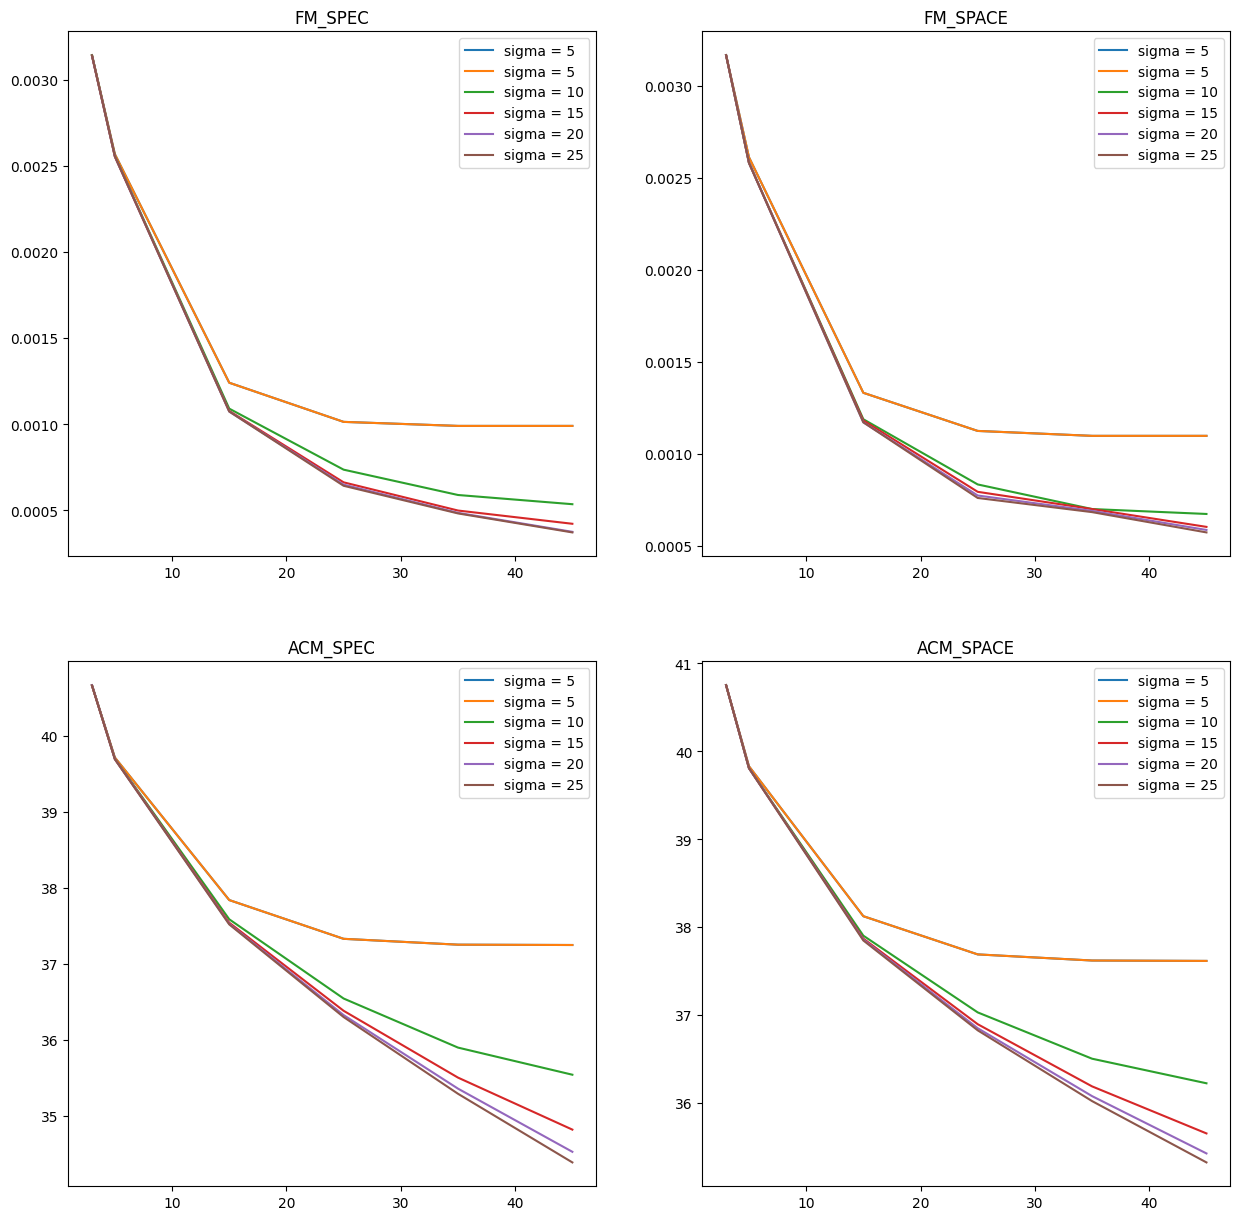

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
for sigma in sigmas:
    axes[0, 0].plot(df_metrics[df_metrics['sigma']==sigma]['k_size'], df_metrics[df_metrics['sigma']==sigma]['FM_SPEC'], label=f'sigma = {sigma}')
    axes[1, 0].plot(df_metrics[df_metrics['sigma']==sigma]['k_size'], df_metrics[df_metrics['sigma']==sigma]['ACM_SPEC'], label=f'sigma = {sigma}')
    axes[0, 1].plot(df_metrics[df_metrics['sigma']==sigma]['k_size'], df_metrics[df_metrics['sigma']==sigma]['FM_SPACE'], label=f'sigma = {sigma}')
    axes[1, 1].plot(df_metrics[df_metrics['sigma']==sigma]['k_size'], df_metrics[df_metrics['sigma']==sigma]['ACM_SPACE'], label=f'sigma = {sigma}')
axes[0, 0].set_title('FM_SPEC')
axes[0, 0].legend()
axes[1, 0].set_title('ACM_SPEC')
axes[1, 0].legend()
axes[0, 1].set_title('FM_SPACE')
axes[0, 1].legend()
axes[1, 1].set_title('ACM_SPACE')
axes[1, 1].legend()



### En todos los casos se observa que las metricas de sharpnes (FM y ACM) son similares para los dos metodos de filtrado (espectral y espacial).
### Cabe aclarar que la comparacion es entre metodos y no entre metricas.